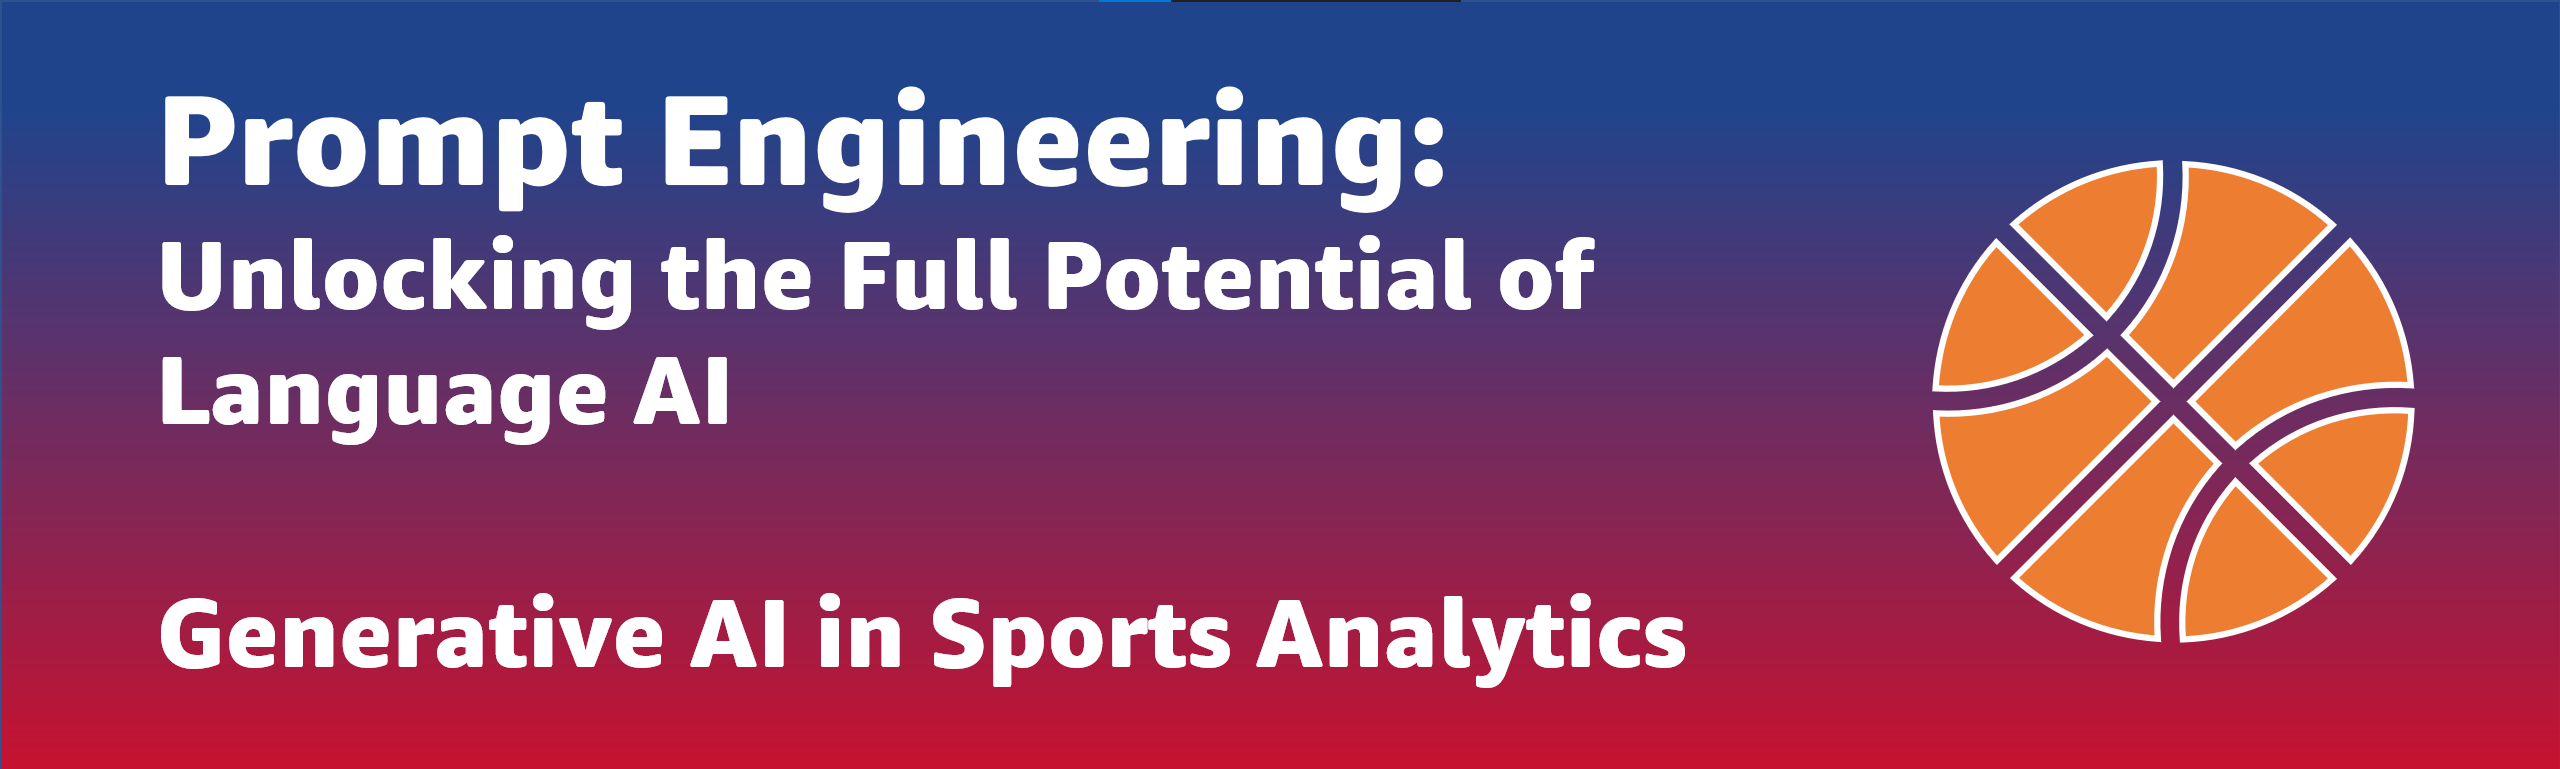

In [12]:
%pip install -U "boto3" "botocore"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.0 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.84
    Uninstalling botocore-1.34.84:
      Successfully uninstalled botocore-1.34.84
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.84
    Uninstalling boto3-1.34.84:
      Successfully uninstalled boto3-1.34.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.84 requires botocore==1.34.84, but you have botocore 1.34.127 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [140]:
import json
import boto3
from helpers import *

In [141]:
bedrock_runtime = boto3.client('bedrock-runtime')
bedrock_agent_runtime = boto3.client('bedrock-agent-runtime')

# Basic Text Generation
- Method: Invoke an Amazon Bedrock model with the Converse API
- LLM: Anthropic Claude 3 Haiku
- Reference: https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference.html

In [158]:
 def invoke_anthropic_model(modelId, prompt):
        inferenceConfig = { 
            "maxTokens": 400,
            "temperature": 0
        }
        messages = [{
            "role": "user",
            "content": [{
                "text": prompt
            }]
        }]
        response = bedrock_runtime.converse(
            messages = messages,
            inferenceConfig = inferenceConfig,
            modelId = modelId
        )
        return response['output']['message']['content'][0]['text']

In [159]:
modelId = "anthropic.claude-3-haiku-20240307-v1:0"
prompt = """What is the NBA?"""

In [160]:
print(invoke_anthropic_model(modelId, prompt))

The NBA (National Basketball Association) is the premier professional basketball league in the United States and Canada. Some key facts about the NBA:

- It was founded in 1946 as the Basketball Association of America (BAA) and adopted the name NBA in 1949 after merging with the National Basketball League (NBL).

- It consists of 30 teams divided into two conferences (Eastern and Western) and six divisions.

- The NBA season runs from October through June, with a regular season followed by a postseason tournament called the NBA Playoffs that culminates in the NBA Finals.

- Some of the most famous and successful NBA teams include the Los Angeles Lakers, Golden State Warriors, Chicago Bulls, Boston Celtics, and Miami Heat.

- The NBA features many of the world's best basketball players and is considered one of the major professional sports leagues in North America, along with the NFL, MLB, and NHL.

- The NBA is known for its high-scoring, fast-paced gameplay, as well as the popularity 

# Question answering for factual questions
- Method: Single Document Retrieval Augmented Generation (RAG) with Bedrock Knowledge Bases
- LLM: Anthropic Claude 3 Sonnet
- Reference: https://aws.amazon.com/blogs/machine-learning/knowledge-bases-in-amazon-bedrock-now-simplifies-asking-questions-on-a-single-document/

In [317]:
region = 'us-west-2'
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
model_arn = f'arn:aws:bedrock:{region}::foundation-model/{model_id}'
document_uri = "s3://prompt-engineering-summit24-demo/2023–24_NBA_season_short.pdf"
session_id = None

In [318]:
def retrieveAndGenerate(input_text):
    global session_id
    input = {'text': input_text}
    config = {
        'type': 'EXTERNAL_SOURCES',
        'externalSourcesConfiguration': {
            'modelArn': model_arn,
            'sources': [
                {
                    "sourceType": "S3",
                    "s3Location": {
                        "uri": document_uri  
                    }
                }
            ]
        }
    }
    if session_id is not None:
        response = bedrock_agent_runtime.retrieve_and_generate(
            input = input,
            retrieveAndGenerateConfiguration = config,
            sessionId = session_id
        )
    else:
        response = bedrock_agent_runtime.retrieve_and_generate(
            input = input,
            retrieveAndGenerateConfiguration = config
        )
        session_id = response['sessionId']
    
    return response['output']['text']

In [319]:
# Evaluate using LLM as Judge
def evaluate(text, test_num):
    model_id = "anthropic.claude-3-haiku-20240307-v1:0"
    ground_truth = [
        "Luka Dončić scored 33.9 points per game.",
        "Oklahoma City Thunder had 38.9% 3-point shooting percentage.",
        "Luka Dončić and Jayson Tatum both won Player of the Month multiple times.",
        "Average wins by Division: Atlantic - 43.6, Central - 39.4, Northwest - 44.4, Pacific - 47.8, Southeast - 33.0, Southwest - 37.8"
    ]
    prompt = """
    You are given two strings: input and ground truth.
    Your role is to answer whether the input string conveys the same meaning as the ground truth string.
    If the meaning is the same answer with PASS. If the meaning is not the same answer with FAIL.
    <input>""" + text + """</input>
    <ground-truth>""" + ground_truth[test_num] + """</ground-truth>
    <answer>
    """
    pass_html = "<td width='10%'><img src='images/pass.png' width='60' height='60'></td>"
    fail_html = "<td width='10%'><img src='images/fail.png' width='60' height='60'></td>"
    text_html = "<td><font size='3'>"+text+"</font></td>"
    rulling = invoke_anthropic_model(model_id, prompt).split()[0]
    if rulling == "PASS":
        display(Markdown('<table><tr>' + pass_html + text_html + '</tr></table>'))
    elif rulling == "FAIL":
        display(Markdown('<table><tr>' + fail_html + text_html + '</tr></table>'))
    else:
        display(Markdown("Could not evaluate: " + rulling + " - " + text_html))

In [320]:
evaluate(retrieveAndGenerate("Who scored the most points per game?"), 0)

<table><tr><td width='10%'><img src='images/pass.png' width='60' height='60'></td><td><font size='3'>Luka Dončić of the Dallas Mavericks scored the most points per game in the 2023-24 NBA season with 33.9 points per game.</font></td></tr></table>

In [321]:
evaluate(retrieveAndGenerate("Which team has the best 3 points average?"),1)

<table><tr><td width='10%'><img src='images/pass.png' width='60' height='60'></td><td><font size='3'>The NBA team with the best 3-point shooting percentage in the 2023-24 season was the Oklahoma City Thunder, who shot 38.9% from 3-point range.</font></td></tr></table>

In [324]:
evaluate(retrieveAndGenerate("Who was player of the month twice?"),2)

<table><tr><td width='10%'><img src='images/pass.png' width='60' height='60'></td><td><font size='3'>Jayson Tatum of the Boston Celtics was named the Eastern Conference Player of the Month twice during the 2023-24 NBA season - in October/November and February. Luka Dončić of the Dallas Mavericks was named the Western Conference Player of the Month twice during the 2023-24 NBA season - in February and March.</font></td></tr></table>

### Let's try something more difficult. Can the LLM calculate averages?

In [325]:
question = "What is the average number of wins for  each division?"

In [326]:
evaluate(retrieveAndGenerate(input_text = question),3)

<table><tr><td width='10%'><img src='images/fail.png' width='60' height='60'></td><td><font size='3'>Here are the average wins by division for the 2023-24 NBA season:

Atlantic Division: 47.0 wins
Central Division: 41.8 wins
Southeast Division: 35.0 wins
Northwest Division: 44.4 wins
Pacific Division: 48.0 wins
Southwest Division: 39.8 wins</font></td></tr></table>

<font color='red'>Hmm, these numbers are incorrect. The LLM is hallucinating.</font>

# Summary Statistics
- Method: Text2SQL
- Model: Mistral AI - Mistral 7B Instruct
- Reference: https://aws.amazon.com/blogs/machine-learning/generating-value-from-enterprise-data-best-practices-for-text2sql-and-generative-ai/

In [275]:
def invoke_mistral_model(prompt, modelId):
    request_body = json.dumps({
        "prompt": "<s>[INST] " + prompt + " [/INST]",
        "max_tokens" : 100, 
        "temperature" : 0, 
        "top_p" : 0.9, 
        "top_k" : 50
    })
    response = bedrock_runtime.invoke_model(
            body = request_body,
            modelId = modelId
    )
    response_body = json.loads(response.get("body").read())
    return response_body.get('outputs')[0].get('text')

In [276]:
prompt = """
You task is to generate SQL. Generate the simplest SQL statement. Output only SQL.
Given a table called "Teams" with the following columns:
Team	W	L	PCT	GB	Home	Road	GP	Division
where 'W' stands for wins and 'L' stands for losses,
Write a SQL statement to answer the question:
""" + question + """

```sql
"""

In [277]:
mistral7b = "mistral.mistral-7b-instruct-v0:2"
statement = invoke_mistral_model(prompt, mistral7b)
prettyPrint(statement)

<font size="3"> SELECT Division, AVG(W) as AvgWins
FROM Teams
GROUP BY Division;</font>

### Execute the SQL Query

In [282]:
import pandas as pd
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine

def prepSQLDB(csv):
    df = pd.read_csv(csv, delimiter='\t')
    engine = create_engine("sqlite:///Teams.db")
    df.to_sql("Teams", engine, index=False)

def querySQL(statement):
    engine = create_engine("sqlite:///Teams.db")
    db = SQLDatabase(engine=engine)
    return db.run(statement)

In [ ]:
prepSQLDB('Teams.csv')

In [283]:
res = querySQL(statement)
prettyJSON(res)


```json
[('Atlantic', 43.6), ('Central', 39.4), ('Northwest', 44.4), ('Pacific', 47.8), ('Southeast', 33.0), ('Southwest', 37.8)]
```


### Generate final answer

In [285]:
prompt = "The following data is average wins per division: " + res + ". Question: " + question
evaluate(invoke_mistral_model(prompt, mistral7b), test_num = 3)

<table><tr><td width='10%'><img src='images/pass.png' width='60' height='60'></td><td><font size='3'> The average number of wins for each division based on the given data is as follows:

- Atlantic Division: 43.6 wins
- Central Division: 39.4 wins
- Northwest Division: 44.4 wins
- Pacific Division: 47.8 wins
- Southeast Division: 33.0 wins
- Southwest Division: 37.8 wins</font></td></tr></table>

# Data Analysis
- Method: Chain of Code (CoC)
- Model: Mistral AI - Mistral Large
- References: https://chain-of-code.github.io/paper.pdf

In [287]:
prompt = """
You are an expert Python programmer. Your task is to generate efficient Python code to accomplish a given task.
You must answer with code only. Do not add any text beyond the generated code.
###
Given a tab-delimited CSV file called “Teams.csv” with the following columns:
Team	W	L	PCT	GB	Home	Road	GP	Division
where 'W' stands for wins and 'L' stands for losses,
Write Python code to to answer the question:
""" + question + """
"""

In [289]:
code = invoke_mistral_model(prompt, "mistral.mistral-large-2402-v1:0")
prettyCode(code)

 ```python
import pandas as pd

# Read the CSV file
df = pd.read_csv('Teams.csv', delimiter='\t')

# Calculate the average number of wins for each division
avg_wins_per_division = df.groupby('Division')['W'].mean()

# Print the result
print(avg_wins_per_division)
```

### Execute the Python code

In [327]:
%%capture out
# Note: Handle with care!
exec(code.replace('```python', '').replace('```', ''))

### Generate final answer

In [309]:
prompt = "The following data is average wins per division: " + out.stdout + ". Question: " + question
evaluate(invoke_mistral_model(prompt, mistral7b), test_num = 3)

<table><tr><td width='10%'><img src='images/pass.png' width='60' height='60'></td><td><font size='3'> The average number of wins for each division is as follows:

- Atlantic: 43.6 wins
- Central: 39.4 wins
- Northwest: 44.4 wins
- Pacific: 47.8 wins
- Southeast: 33.0 wins
- Southwest: 37.8 wins

So, the average number of wins for each division is given in the data you provided.</font></td></tr></table>

# Data Visualization
- Method: Chain of Code (CoC) - Using PandasAI
- Model: Mistral AI - Anthropic Claude Sonnet
- References: https://pandas-ai.com/

In [27]:
%pip install pandasai[bedrock]

  Using cached astor-0.8.1-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached Faker-19.13.0-py3-none-any.whl.metadata (15 kB)
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 28.9 MB/s eta 0:00:00:00:0100:01
Using cached Faker-19.13.0-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 3.2 MB/s eta 0:00:00:00:01
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.0/384.0 kB 3.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 2.5 MB/s eta 0:00:00ta 0:00:01
  A

In [166]:
from pandasai import SmartDataframe
from pandasai.connectors import SqliteConnector
from pandasai.llm import BedrockClaude

In [182]:
connector = SqliteConnector(config={
    "database" : "Teams.db",
    "table" : "Teams",
})
llm = BedrockClaude(bedrock_runtime)
df = SmartDataframe(connector, config={"llm": llm, "open_charts":False})

In [183]:
# # Example Questions
# df.chat("Which team had the most wins?")
# df.chat("How many teams belong to the central division?")
# df.chat("what is the highest pct")
# df.chat("what is the Hornets pct")
# df.chat("what is the Charlotte Hornets pct?")

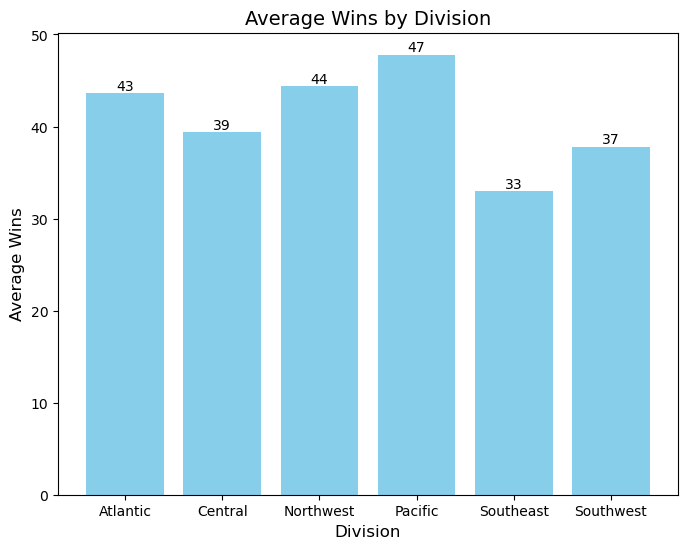

In [189]:
%%capture --no-display
response = df.chat("Chart each division's averge wins. Include data labels.")

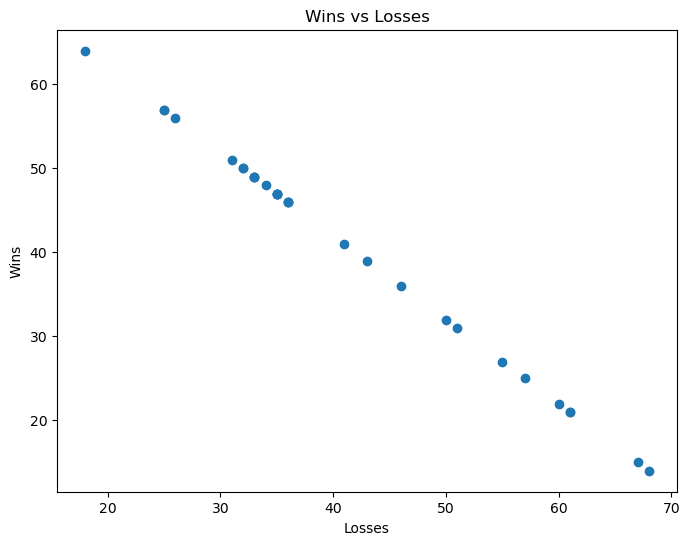

In [190]:
%%capture --no-display
response = df.chat("Draw a scattr plot of wins versus losses. Place wins on the Y axis.")

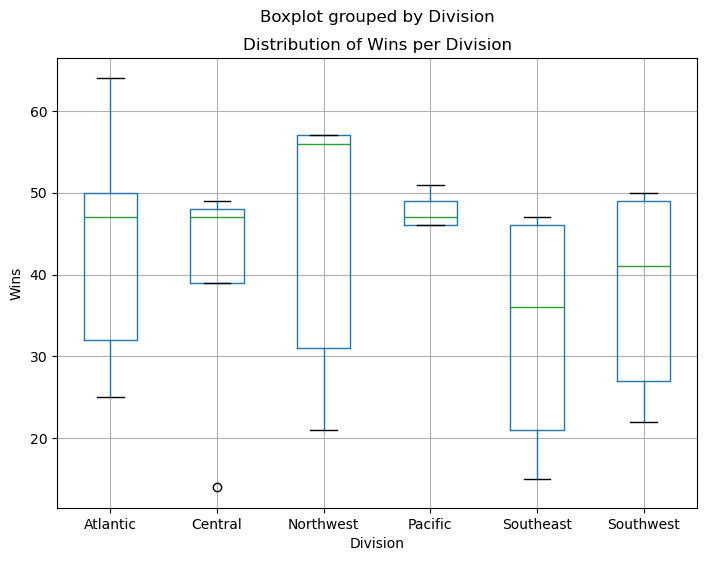

In [191]:
%%capture --no-display
response = df.chat("Draw a boxplot to visualize wins distribution per each division")

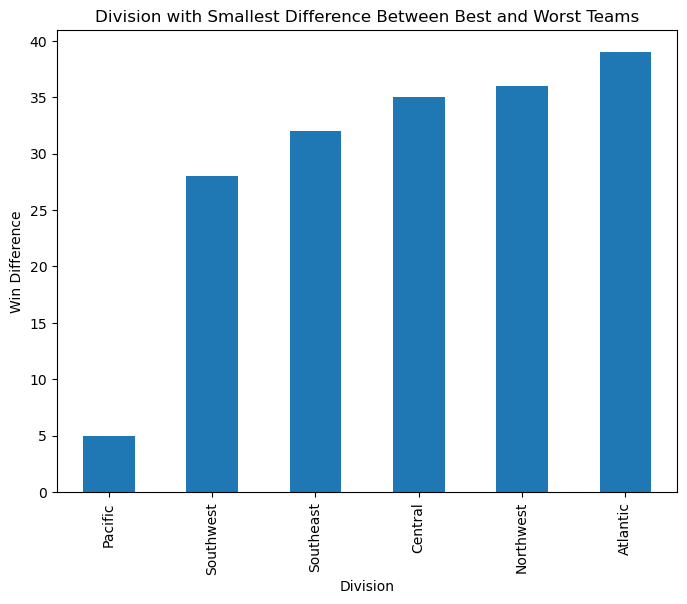

In [195]:
%%capture --no-display
response = df.chat("Draw a chart to show which division has the smallest difference between best and worst teams")

# Conclusion
- Amazon Bedrock is a fully managed service that offers a choice of high-performing foundation models (FMs) from leading AI companies
- With Knowledge Bases for Amazon Bedrock, you can give FMs and agents contextual information from your company’s private data sources
- LLMs can be leveraged for querying relational databases, for data analysis and visualization, however, risks and challenges should be considered